In [ ]:
pip install langgraph-codeact duckdb plotly

In [1]:
import json
# import math
import pandas as pd
import duckdb
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from dotenv import load_dotenv
from langchain_core.tools import tool
from langchain.chat_models import ChatOpenAI
from langgraph_codeact import create_codeact, create_default_prompt
from langgraph.checkpoint.memory import MemorySaver
import builtins
import contextlib
import io
import os
from typing import Any

load_dotenv()

api_key=os.getenv("OPENAI_API_KEY")

if api_key:
    print("Key loaded")
else:
    print("Key is not loaded")

Key loaded




---answer---

 {'messages': [HumanMessage(content='Ignore the visualization tool i have given you. Create a visualization for the average performance of all tickers over time. explaing which data you used. Using the file: ipo_data.xlsx', additional_kwargs={}, response_metadata={}, id='e2c0fe48-d068-4862-80c3-5472c8aee509')]}
To create a visualization for the average performance of all tickers over time, we first need to examine the structure of the `ipo_data.xlsx` file to understand the available data. Let's start by previewing the Excel file structure.

```python
# Preview the structure of the Excel file to understand the data
file_structure = preview_excel_structure('{"file_name": "ipo_data.xlsx"}')
print(file_structure)
```

Once we have the structure, we can identify the relevant columns for the analysis, such as date, ticker, and performance metrics. Then, we can calculate the average performance over time and create a visualization. Let's proceed with these steps.

---answer---

,dealID,proposedTickerSymbol,companyName,proposedExchange,proposedSharePrice,sharesOffered,pricedDate,dollarValueOfSharesOffered,dealStatus,Industry,...,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11,Month 12,Month 13
0,1246500-108172,FBLG,"FibroBiologics, Inc.",NASDAQ Global,30.0,"4,806,226",1/31/2024,"$144,186,780",Priced,Biotechnology,...,-64.83333269755046,-60.03333409627278,-85.03333409627278,-84.10000006357828,-95.30000011126201,-89.00000015894572,-88.69999965031941,-91.40000025431316,-92.7999997138977,nan
1,943692-107037,AMIX,"Autonomix Medical, Inc.",NASDAQ Capital,5.0,"2,234,222",1/29/2024,"$11,171,110",Priced,Medical Devices,...,1146.800003051758,915.9999847412109,320.0,515.9999847412109,152.0000076293945,187.6000022888184,134.4000053405762,112.0000076293945,-33.00000190734863,-45.0
2,1269043-107548,HAO,Haoxi Health Technology Ltd,NASDAQ Capital,4.0,"2,400,000",1/26/2024,"$9,600,000",Priced,Advertising Agencies,...,20.50000429153442,59.74999666213989,55.49999475479126,-0.9999990463256836,-18.00000071525574,-11.00000143051147,-95.69999985396862,-94.92500014603138,-96.44999988377094,-96.20000012218952




---answer---

 {'messages': [HumanMessage(content='Ignore the visualization tool i have given you. Create a visualization for the average performance of all tickers over time. explaing which data you used. Using the file: ipo_data.xlsx', additional_kwargs={}, response_metadata={}, id='e2c0fe48-d068-4862-80c3-5472c8aee509'), AIMessage(content='To create a visualization for the average performance of all tickers over time, we first need to examine the structure of the `ipo_data.xlsx` file to understand the available data. Let\'s start by previewing the Excel file structure.\n\n```python\n# Preview the structure of the Excel file to understand the data\nfile_structure = preview_excel_structure(\'{"file_name": "ipo_data.xlsx"}\')\nprint(file_structure)\n```\n\nOnce we have the structure, we can identify the relevant columns for the analysis, such as date, ticker, and performance metrics. Then, we can calculate the average performance over time and create a visualization. Let\'s proceed w

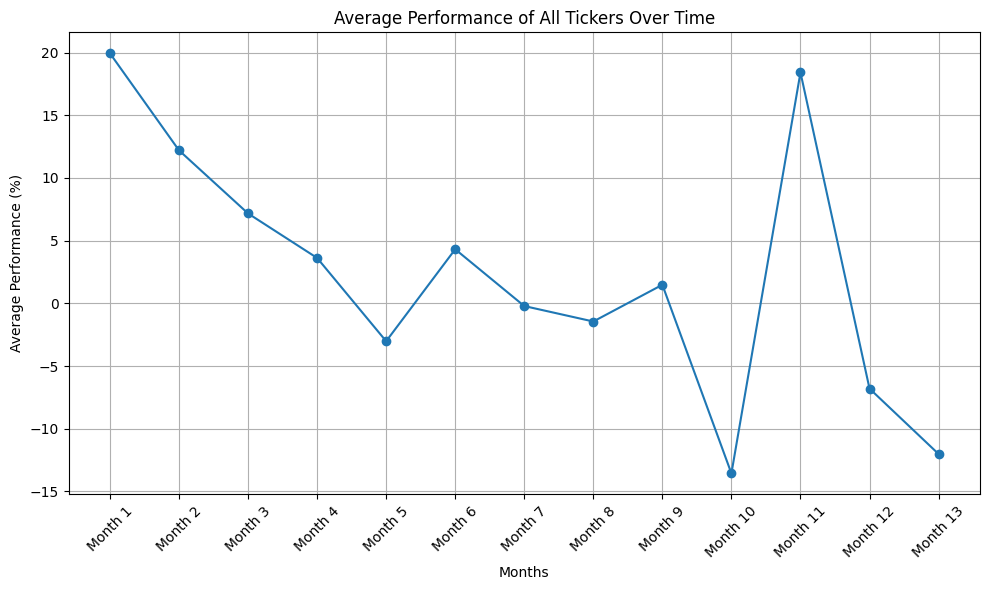



---answer---

 {'messages': [HumanMessage(content='Ignore the visualization tool i have given you. Create a visualization for the average performance of all tickers over time. explaing which data you used. Using the file: ipo_data.xlsx', additional_kwargs={}, response_metadata={}, id='e2c0fe48-d068-4862-80c3-5472c8aee509'), AIMessage(content='To create a visualization for the average performance of all tickers over time, we first need to examine the structure of the `ipo_data.xlsx` file to understand the available data. Let\'s start by previewing the Excel file structure.\n\n```python\n# Preview the structure of the Excel file to understand the data\nfile_structure = preview_excel_structure(\'{"file_name": "ipo_data.xlsx"}\')\nprint(file_structure)\n```\n\nOnce we have the structure, we can identify the relevant columns for the analysis, such as date, ticker, and performance metrics. Then, we can calculate the average performance over time and create a visualization. Let\'s proceed w

In [3]:
def preprocess_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Robust preprocessing of DataFrame to handle empty values."""
    # Convert empty strings and whitespace to None
    df = df.replace(r'^\s*$', None, regex=True)
    # Convert NaN strings to None
    df = df.replace(['nan', 'NaN', 'null'], None)
    # Convert pandas NaN to None
    df = df.where(pd.notnull(df), None)
    return df


@tool
def preview_excel_structure(input_str: str) -> str:
    """Use this first to examine the Excel file structure and data types. 
    The input should be a JSON string with format: {"file_name": "your_file.xlsx"}"""
    try:
        data = json.loads(input_str)
        file_name = data.get("file_name")
        if not file_name:
            return json.dumps({"error": "File name must be provided"})
            
        df = pd.read_excel(file_name)
        df = preprocess_dataframe(df)  # Apply preprocessing
        df_sample = df.head(3).astype(str)
        print("✅ Preview successful")
        display(df_sample)
        return json.dumps({
            "result": {
                "columns": df.columns.tolist(),
                "dtypes": df.dtypes.astype(str).to_dict(),
                "sample_rows": df_sample.to_dict(orient="records")
            }
        })
    except Exception as e:
        return json.dumps({"error": str(e)})
        

@tool
def complex_duckdb_query(input_str: str) -> str:
    """Use this for complex SQL operations (GROUP BY, aggregations, etc.).
    The input should be a JSON string with format: 
    {"file_name": "your_file.xlsx", "query": "your SQL query"}
    Note: Use 'data' as the table name in your SQL queries."""
    try:
        data = json.loads(input_str)
        file_name = data.get("file_name")
        query = data.get("query")
        if not file_name or not query:
            return json.dumps({"error": "Both file_name and query must be provided"})

        print("\n🔍 Executing DuckDB query:")
        print(query)

        # ✅ Set the last executed query in the global state
        global state  # Ensure state is accessible
        if state is not None:
            state['last_query'] = query
        # state['last_query'] = str(query)
        
        # Read and preprocess the Excel file to handle empty values
        df = pd.read_excel(file_name)
        df = preprocess_dataframe(df)  # Clean the data upfront
        
        with duckdb.connect() as con:
            # Register dataframe with a consistent table name 'data'
            con.register("data", df)
            result = con.execute(query).fetchdf()
            print("✅ Query successful")
            display(result)
            
            # Handle different types of results robustly
            if result is None:
                return json.dumps({"result": None})
                
            if isinstance(result, pd.DataFrame):
                # Handle DataFrame results
                try:
                    # Replace various null/nan types with None
                    df_processed = result.copy()
                    
                    # Handle infinite values
                    df_processed = df_processed.replace([float('inf'), -float('inf')], None)
                    
                    # Replace numpy NaN, pandas NA, and other null types with None
                    df_processed = df_processed.where(pd.notna(df_processed), None)
                    
                    # Ensure all values are JSON serializable
                    for column in df_processed.columns:
                        if df_processed[column].dtype == 'object':
                            df_processed[column] = df_processed[column].apply(
                                lambda x: str(x) if x is not None else None
                            )
                    
                    return json.dumps({
                        "result": {
                            "columns": df_processed.columns.tolist(),
                            "rows": df_processed.to_dict(orient="records")
                        }
                    })
                except Exception as e:
                    return json.dumps({
                        "error": f"Error processing DataFrame: {str(e)}",
                        "result": result.to_string()  # Fallback to string representation
                    })
            else:
                # Handle scalar or other types of results
                try:
                    return json.dumps({"result": result})
                except TypeError:
                    return json.dumps({
                        "result": str(result)  # Fallback to string representation
                    })
            
    except Exception as e:
        return json.dumps({"error": str(e)})


@tool
def create_visualization(input_str: str) -> str:
    """Create and immediately display various types of visualizations."""
    try:
        # Parse input
        params = json.loads(input_str)
        
        # Extract parameters
        data = params.get("data")
        plot_type = params.get("plot_type", "line")  # Default to line plot
        x = params.get("x")
        y = params.get("y")
        title = params.get("title", "")
        color = params.get("color")
        
        # Additional parameters
        orientation = params.get("orientation", "v")  # For bar charts
        barmode = params.get("barmode", "group")     # For bar charts
        size = params.get("size")                    # For bubble charts
        nbins = params.get("nbins")                  # For histograms

        
        y = params.get("y")
        title = params.get("title", "")
        color = params.get("color")
        
        # Additional parameters
        orientation = params.get("orientation", "v")  # For bar charts
        barmode = params.get("barmode", "group")     # For bar charts
        size = params.get("size")                    # For bubble charts
        nbins = params.get("nbins")                  # For histograms
        
        # Sankey-specific parameters
        source = params.get("source")  # For Sankey diagrams
        target = params.get("target")  # For Sankey diagrams
        value = params.get("value")    
        
        # Validate required parameters
        if not data or not x:
            return "❌ Error: Missing required parameters: data and x."
            
        # Convert data to DataFrame
        if isinstance(data, dict) and "result" in data:
            if "rows" in data["result"]:
                df = pd.DataFrame(data["result"]["rows"])
            else:
                return "❌ Error: Invalid data format."
        else:
            return "❌ Error: Invalid data format."
            
        # Common layout settings
        layout_settings = {
            'title': {
                'text': title,
                'x': 0.5,
                'xanchor': 'center',
                'font': dict(size=16)
            },
            'plot_bgcolor': 'white',
            'paper_bgcolor': 'white',
            'font': dict(size=12),
            'margin': dict(l=50, r=50, t=50, b=100),
            'height': 1000, #600
            'width': 1500, #800
            'template': 'plotly_white'
        }
        
        # Create visualization based on plot type
        if plot_type == "line":
            fig = px.line(df, x=x, y=y, color=color, title=title)
            fig.update_traces(mode='lines+markers')  # Add markers
            
        elif plot_type == "bar":
            fig = px.bar(df, x=x, y=y, color=color, title=title,
                        barmode=barmode, orientation=orientation)
            
        elif plot_type == "scatter":
            fig = px.scatter(df, x=x, y=y, color=color, size=size, 
                           title=title)
            
        elif plot_type == "box":
            fig = px.box(df, x=x, y=y, color=color, title=title)
            
        elif plot_type == "histogram":
            fig = px.histogram(df, x=x, color=color, nbins=nbins, 
                             title=title)
            
        elif plot_type == "pie":
            if not y:  # For pie charts, y is optional (count by default)
                fig = px.pie(df, names=x, color=x, title=title)
            else:
                fig = px.pie(df, names=x, values=y, title=title)
                
        elif plot_type == "heatmap":
            # Pivot data if necessary
            if len(df.columns) < 3:  # If data isn't already in matrix form
                pivot_df = df.pivot(index=y, columns=x, values=color if color else 'value')
                fig = px.imshow(pivot_df, title=title)
            else:
                fig = px.imshow(df, title=title)
        
        elif plot_type == "sankey":
            if not (source and target and value):
                return "❌ Error: Sankey diagrams require 'source', 'target', and 'value' fields."
            
            fig = go.Figure(data=[go.Sankey(
                # arrangement="freeform", #snap, freeform, fixed
                domain=dict(
                    x=[0, 1],
                    y=[0.1, 0.90]  # Adjust these values to reserve space at the top and bottom  y=[0.2, 0.75]  # Leaves 20% space at the top, 25% at the bottom
                ),
                node=dict(
                    pad=70,
                    thickness=30,
                    line=dict(color="black", width=0.9),
                    label=list(set(df[source].tolist() + df[target].tolist()))
                ),
                link=dict(
                    source=df[source].apply(lambda x: list(set(df[source].tolist() + df[target].tolist())).index(x)),
                    target=df[target].apply(lambda x: list(set(df[source].tolist() + df[target].tolist())).index(x)),
                    value=df[value]
                )
            )])
            
            fig.update_layout(title_text=title, 
                              # font_size=16, 
                              font=dict(size=16, family="Arial, sans-serif", color="black"),
                              plot_bgcolor='white', 
                              paper_bgcolor='white', 
                              margin=dict(l=50, r=50, t=50, b=50))
        # Sankey End
            
        else:
            return f"❌ Error: Unsupported plot type: {plot_type}."
        
        # Update layout for all chart types
        fig.update_layout(layout_settings)
        
        # Add gridlines (except for pie and heatmap)
        if plot_type not in ['pie', 'heatmap']:
            fig.update_xaxes(
                showgrid=True, 
                gridwidth=1, 
                gridcolor='LightGray',
                title_text=x.replace('_', ' ').title() if x else ''
            )
            if y:  # Only add y-axis if it exists
                fig.update_yaxes(
                    showgrid=True, 
                    gridwidth=1, 
                    gridcolor='LightGray',
                    title_text=y.replace('_', ' ').title()
                )
        
        # Display the visualization immediately
        fig.show()
        
        return "✅ Visualization displayed successfully."
        
    except Exception as e:
        return f"❌ Visualization error: {str(e)}."


def is_json_serializable(val):
    try:
        json.dumps(val)
        return True
    except (TypeError, OverflowError):
        return False

def eval(code: str, _locals: dict[str, Any]) -> tuple[str, dict[str, Any]]:
    original_keys = set(_locals.keys())

    try:
        with contextlib.redirect_stdout(io.StringIO()) as f:
            exec(code, builtins.__dict__, _locals)
        result = f.getvalue() or "<code ran, no output printed to stdout>"
    except Exception as e:
        result = f"Error during execution: {repr(e)}"

    new_keys = set(_locals.keys()) - original_keys

    # Automatically exclude non-serializable values
    new_vars = {
        key: _locals[key]
        for key in new_keys
        if is_json_serializable(_locals[key])
    }

    return result, new_vars



# System Prompt. You must prompt the agent to use the tools it has been given, if you want to.
SYSTEM_PROMPT = """You are an Excel analysis expert that helps users analyze Excel files using SQL. You must follow this process, when user asks you to use the given tools:

1. ALWAYS preview the Excel file first using preview_excel_structure.
2. ALWAYS use tool `complex_duckdb_query` for SQL logic.
4. If a visualization is requested or helpful, query the data using the `complex_duckdb_query` tool and then pass it to create_visualization.

Always validate SQL logic before execution, exclude rows with NULL/negative values, and ensure proper aggregation and formatting. Visualizations must be well-labeled and accurate.


IMPORTANT: All tool inputs must be properly formatted JSON strings. Examples:

1. Preview Excel:
{"file_name": "example.xlsx"}

2. DuckDB Query with proper empty value handling:
{"file_name": "example.xlsx", "query": "WITH metrics AS (SELECT CASE WHEN price >= 0 AND price < 5 THEN '0-5' ELSE '5+' END as range, value FROM data WHERE value IS NOT NULL) SELECT range, AVG(value) as avg_val FROM metrics GROUP BY range"}


**Visualization Output Format (CRITICAL):**
1. When creating visualizations, ALWAYS return a properly formatted JSON with:
   ```json
   {
      "data": {
        "result": {
          "rows": [...],
          "columns": [...]
        }
      },
      "plot_type": "...",
      "x": "...",
      "y": "...",
      "color": "...",
      "title": "..."
    }
   ```
   **Sankey example:**
 {
  "data": {
    "result": {
      "rows": [
        { "source": "Company", "target": "Contacted by recruiter", "value": 1 },
        { "source": "Contacted by recruiter", "target": "Recruiter interview", "value": 16 },
        { "source": "Recruiter interview", "target": "1st round", "value": 7 },
        { "source": "1st round", "target": "Challenge / Assignment", "value": 4 },
        { "source": "Challenge / Assignment", "target": "2nd round", "value": 4 },
        { "source": "2nd round", "target": "3rd round", "value": 1 },
        { "source": "3rd round", "target": "Opening closed / put on hold", "value": 1 },
        { "source": null, "target": "1st round", "value": 6 },
      ],
      "columns": ["source", "target", "value"]
    }
  },
  "plot_type": "sankey",
  "title": "Job Application Process Transitions",
  "x": "source",
  "source": "source",
  "target": "target",
  "value": "value"
}
   
2. The plotly figure MUST include proper layout settings:
   - height and width specifications
   - proper axis titles
   - grid settings
   - template specification

3. NEVER return raw figure objects or display directly - always convert to JSON

"""

# Agent Initialization
tools = [
    preview_excel_structure,
    complex_duckdb_query,
    create_visualization,
]

llm = ChatOpenAI(model="gpt-4o", temperature=0)

code_act = create_codeact(
        llm, 
        tools, 
        eval, 
        prompt=create_default_prompt(
            tools,
            "Once you have the final answer, respond to the user with plain text, do not respond with a code snippet.",
    ),
)

agent = code_act.compile(checkpointer=MemorySaver())


# Run Agent - Use this, in case you don't want to see the verbose output!
# def run_agent(file_name: str, user_query: str):
#     messages = [{"role": "user", "content": f"{user_query} Using the file: {file_name}"}]
#     result = agent.invoke({"messages": messages}, config={"configurable": {"thread_id": 1}})
#     print("\n\n📊 Final Output:\n", result)


# Run Agent Without Streaming
# run_agent(
#     file_name="ipo_data_2024.xlsx",
#     user_query="How many rows in my excel."
# )

# Run Agent & Stream Output
from langchain_core.runnables import RunnableConfig
def stream_from_agent(messages: list[dict], config: RunnableConfig):
    for typ, chunk in agent.stream(
        {"messages": messages},
        stream_mode=["values", "messages"],
        config=config,
    ):
        if typ == "messages":
            print(chunk[0].content, end="")  # Model reply
        elif typ == "values":
            print("\n\n---answer---\n\n", chunk)  # Final result / output

if __name__ == "__main__":
    config = {"configurable": {
                "thread_id": 1,
                "recursion_limit": 10,  # default (25)
                }
             }

    stream_from_agent(
        [
            {
                "role": "user",
                "content": "Ignore the visualization tool i have given you. Create a visualization for the average performance of all tickers over time. explaing which data you used. Using the file: ipo_data.xlsx",
                # "content": "Ignore the visualization tool i have given you. Create a visualization out of the data in my file using your own logic. I just want it to be a sankey visualization. Use the file: ipo_data.xlsx",
                # "content": "A batter hits a baseball at 45.847 m/s at an angle of 23.474° above the horizontal. The outfielder, who starts facing the batter, picks up the baseball as it lands, then throws it back towards the batter at 24.12 m/s at an angle of 39.12 degrees. How far is the baseball from where the batter originally hit it? Assume zero air resistance.",
            }
        ],
        config,
    )
